## Aplikasi Pengukur ukuran tubuh untuk mengukur ukuran pakaian menggunakan CNN HOURGLASS ARCHITECTURE


#TODO : build the model
and build a function to turn data back from normalization :

#### Libary Used

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import ResNet50
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import os
import pandas as pd
from Parser.KeypointParser import KeypointParser, process_sample
import csv

#### Directories Path  

In [16]:
NOTEBOOK_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(ROOT_DIR, "data", "LIP")
IMAGE_DIR = os.path.join(DATA_DIR, "images")
ANNOTATION_DIR = os.path.join(DATA_DIR, "pose_annotations")
IMAGE_ID_DIR = os.path.join(IMAGE_DIR, "image_id")
WEIGHT_DIR = os.path.join(ROOT_DIR, "pretrained_weights")
IMAGE_SHAPES_DIR = os.path.join(IMAGE_DIR, "shapes")

#### Hyper Parameters used


In [13]:
IMAGE_SIZE = (256, 256)
TOTAL_DATA = 3200
BATCH_SIZE = 32

### Custom Preprocessing Data and Labels 

In [14]:
def read_image_id_file(filepath):
        with open(filepath, "r") as file:
            data = file.readlines()
            return np.array([line.strip() for line in data])


def preprocess_image_as_tensor(image_id, image_size, subset):    
    base_path = os.path.join(IMAGE_DIR, subset)
    base_path = tf.convert_to_tensor(base_path, dtype=tf.string)
    image_path = tf.strings.join([base_path, image_id], separator=os.path.sep)
    image_path = tf.strings.join([image_path, '.jpg'], separator='')
    
    t_image = tf.io.read_file(image_path)
    t_image = tf.image.decode_jpeg(t_image, channels=3)
    # t_image = tf.image.rgb_to_grayscale(t_image)
    t_image = tf.image.resize(t_image, image_size)
    t_image /= 255.0
    
    return t_image

def load_images_to_tensor(image_ids, image_size, subset):
    dataset = tf.data.Dataset.from_tensor_slices(image_ids)
    
    # Wrap the preprocess_image function to pass the additional arguments
    preprocess_fn = lambda x: preprocess_image_as_tensor(x, image_size, subset)
    
    dataset = dataset.map(
        preprocess_fn,
        num_parallel_calls=tf.data.AUTOTUNE 
    )
    return dataset

def create_image_shape():
    for subset in ["train", "test", "val"]:
        os.makedirs(IMAGE_SHAPES_DIR, exist_ok=True)
        shapes_file_name = os.path.join(IMAGE_SHAPES_DIR, f"shape_{subset}.csv")
        
        if(os.path.exists(os.path.join(shapes_file_name))):
            print(f"{shapes_file_name} already exists. Skipping...")
            continue
        
        images_shape = []
        image_ids_path = os.path.join(IMAGE_ID_DIR, f"{subset}_id.txt")
        images = read_image_id_file(image_ids_path)
        for img_name in images:
            img = cv2.imread(os.path.join(IMAGE_DIR, subset,  f"{img_name}.jpg"))
            x, y = img.shape[:2]
            images_shape.append((img_name, x, y))

        shapes_file_name = f"shape_{subset}.csv"
        
        with open(IMAGE_SHAPES_DIR, shapes_file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Image Name', 'Height', 'Width'])
            writer.writerows(images_shape)

        print(f"Image shapes have been saved to {shapes_file_name}")

def load_image_shapes(image_shapes_path):
    shapes = []
    image_shapes_df = pd.read_csv(image_shapes_path)
    for _, shape in image_shapes_df.iterrows():
        shapes.append((shape['Height'], shape['Width']))
    return shapes

def load_keypoints_to_tensor(subset, parser: KeypointParser):
    annotations_np = pd.read_csv(
            os.path.join(ANNOTATION_DIR, f"{subset}.csv"),
            header=None,
            index_col=0
    ).to_numpy()
    
    shapes = load_image_shapes(os.path.join(IMAGE_SHAPES_DIR, f"shape_{subset}.csv"))
    heights = np.array([shape[0] for shape in shapes])
    widths = np.array([shape[1] for shape in shapes])

    scale_factor_y = IMAGE_SIZE[0] / heights
    scale_factor_x = IMAGE_SIZE[1] / widths
    scale_factor = (scale_factor_x, scale_factor_y)
    
    keypoints = parser.process_keypoints_csv(annotations_np, scale_factor, IMAGE_SIZE)
        
    keypoint_t = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    return tf.data.Dataset.from_tensor_slices(keypoint_t)

In [5]:
create_image_shape()

c:\Users\NAN0C\Documents\Kuliah\Skripsi\prototype\data\LIP\images\shapes\shape_train.csv already exists. Skipping...
c:\Users\NAN0C\Documents\Kuliah\Skripsi\prototype\data\LIP\images\shapes\shape_test.csv already exists. Skipping...
c:\Users\NAN0C\Documents\Kuliah\Skripsi\prototype\data\LIP\images\shapes\shape_val.csv already exists. Skipping...


#### Prepare Dataset (train, Validation, Test)

In [17]:
parser = KeypointParser(DATA_DIR)

def load_dataset(subset, parser, num_samples=None):
    image_ids_path = os.path.join(IMAGE_ID_DIR, f"{subset}_id.txt")
    image_ids = read_image_id_file(image_ids_path)    
    total_samples = len(image_ids) if num_samples is None else num_samples

    images = load_images_to_tensor(image_ids, IMAGE_SIZE, subset)
    annotations = load_keypoints_to_tensor(subset, parser)
    
    dataset = tf.data.Dataset.zip((images, annotations))
    buffer_size = int(0.1 * len(image_ids))    
    dataset = (
        dataset
        .cache()
        .shuffle(buffer_size=buffer_size)
        .take(total_samples)
        .batch(batch_size=BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    return dataset

#### Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.0833),  # +/- 30 degrees (30/360 ≈ 0.0833)
    tf.keras.layers.RandomZoom(0.25, 0.25)  # Scale between 0.75 and 1.25
])

#### Creating the dataset

In [19]:
kp_parser = KeypointParser(DATA_DIR)

train_ds = load_dataset("train", kp_parser, TOTAL_DATA)

# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

val_ds = load_dataset("val", kp_parser, TOTAL_DATA)

train_cardi = tf.data.experimental.cardinality(train_ds).numpy()
val_cardi = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Number of training samples: {train_cardi}")
print(f"Number of validation samples: {val_cardi}")

for img_t, anno_t in train_ds.take(1):
    print(f"Image Shape: {img_t.shape}")
    print(f"annotation Shape: {anno_t.shape}")

Cause: Unable to locate the source code of <function join at 0x00000155F8DAC680>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function join at 0x00000155F8DAC680>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.auto

#### Visualize the Data

In [118]:
def draw_keypoints(parser: KeypointParser, ax, image, keypoints, label): 
    
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # Draw keypoints
    for i, (x, y) in enumerate(keypoints):
        # Draw the keypoint
        if x > 0 or y > 0:
            cv2.circle(image, (int(x), int(y)), 5, parser.COLORS[i], -1)
            cv2.putText(
                    image,
                    parser.KEYPOINTS[i + 1],
                    (int(x), int(y) - 10),
                    cv2.FONT_HERSHEY_PLAIN,
                    0.8,
                    parser.COLORS[i],
                    1,
                )

    # Draw connections
    for _, connection in parser.CONNECTED_JOINTS.items():
        start_idx, end_idx = connection
        if start_idx <= len(keypoints) and end_idx <= len(keypoints):
            x_start, y_start = keypoints[start_idx - 1]
            x_end, y_end = keypoints[end_idx - 1]
            
            if x_start > 0 and y_start > 0 and x_end > 0 and y_end > 0:
                ax.plot([x_start, x_end], [y_start, y_end], color='white', linewidth=10)
    
    # Display the image
    ax.imshow(image)
    ax.set_title(label, fontsize=64)
    return ax

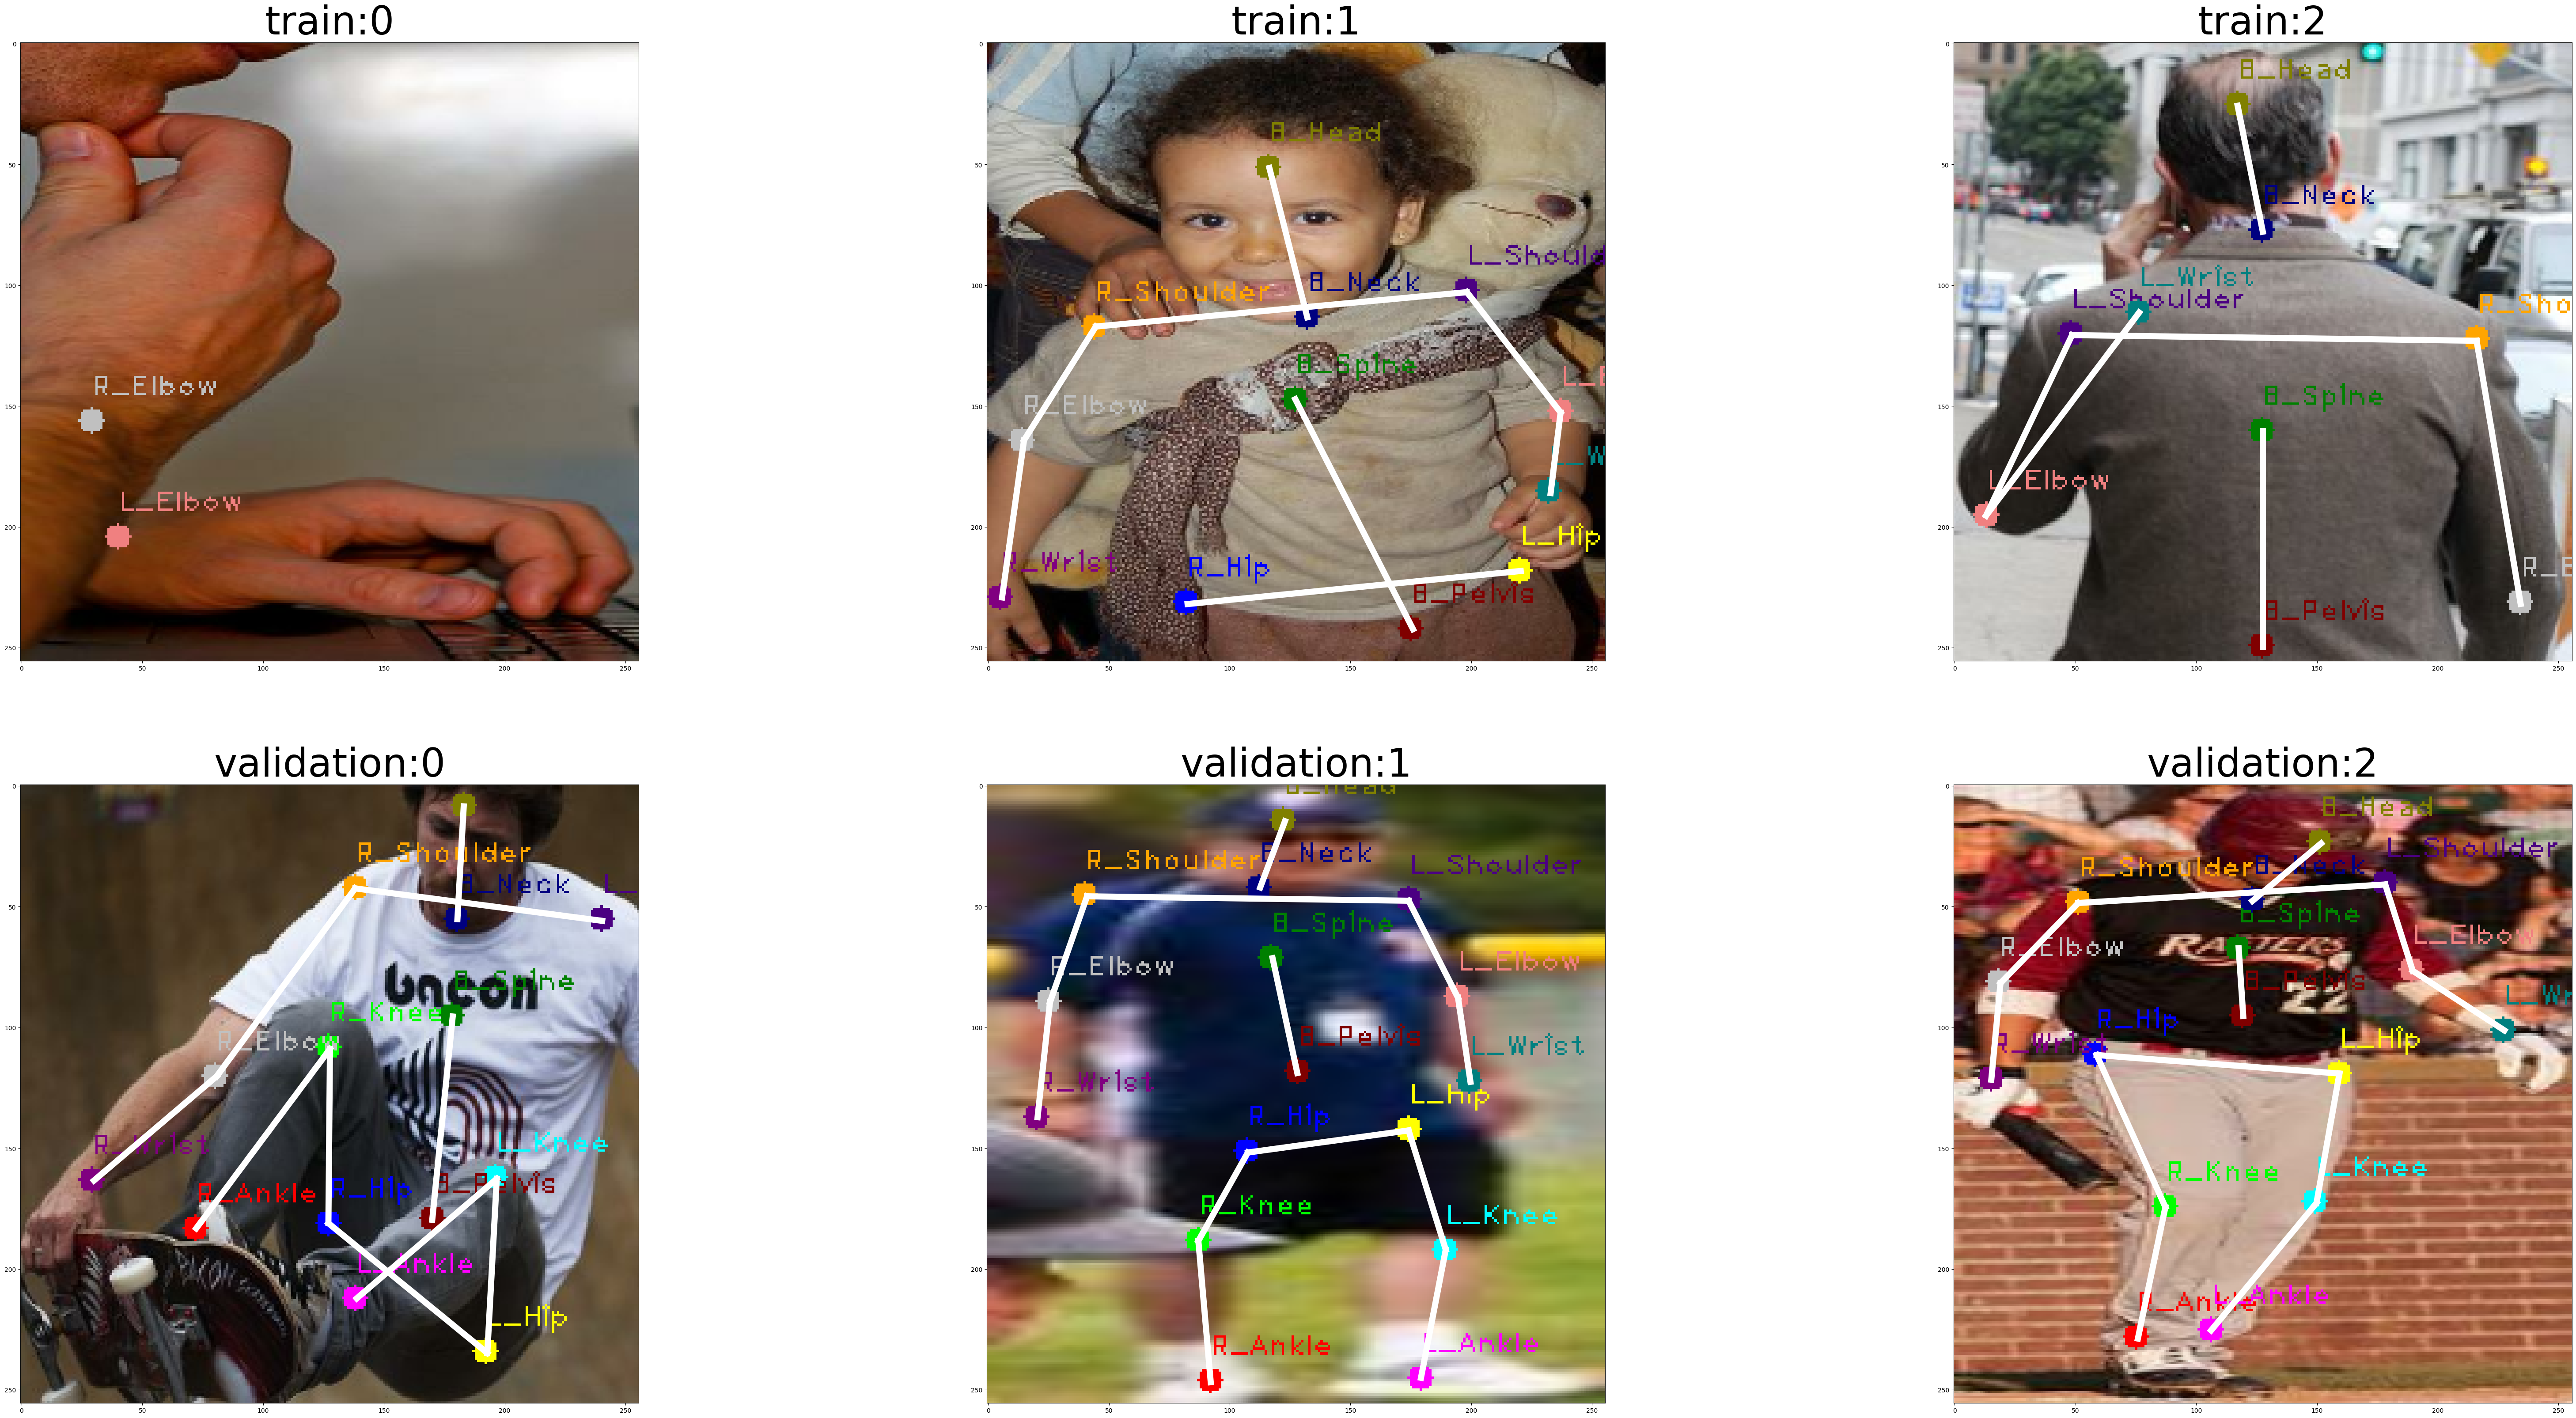

In [119]:
example_train = {
    'images': [],
    'annotations': []
}
example_val= {
    'images': [],
    'annotations': []
}

for image, annotation in train_ds.take(3): 
    example_train['images'].append(image[0].numpy() * 255)
    example_train['annotations'].append(annotation[0].numpy() * IMAGE_SIZE[0])
    
for image, annotation in val_ds.take(3): 
    example_val['images'].append(image[0].numpy() * 255)
    example_val['annotations'].append(annotation[0].numpy() * IMAGE_SIZE[0])


num_images = len(example_train['images'])
fig, axs = plt.subplots(2, num_images, figsize=(80, 40))

# Plot training images with labels
for i in range(num_images):    
    train_img = example_train['images'][i].astype("uint8")
    train_kp = example_train['annotations'][i]
    val_img = example_val['images'][i].astype("uint8")
    val_kp = example_val['annotations'][i]
    draw_keypoints(parser, axs[0, i], train_img, train_kp, f"train:{i}")
    draw_keypoints(parser, axs[1, i], val_img, val_kp, f"validation:{i}")
plt.show()

#### Creating the Model

In [10]:
def residual_block(x, filters):
    # Simple residual block with skip connection.
    skip = layers.Conv2D(filters, 1, padding='same')(x)
    skip = layers.BatchNormalization()(skip)
    
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, skip]) # create the skip connection
    return layers.ReLU()(x)

def hourglass_module(x, filters, num_keypoints):
    # Down-sampling path
    down1 = residual_block(x, filters)  # Down sample to 64 x 64
    down1_pool = layers.MaxPooling2D(pool_size=(2, 2))(down1)  # Pooling to 32 x 32

    down2 = residual_block(down1_pool, filters)  # Down sample to 32 x 32
    down2_pool = layers.MaxPooling2D(pool_size=(2, 2))(down2)  # Pooling to 16 x 16

    down3 = residual_block(down2_pool, filters)  # Down sample to 16 x 16
    down3_pool = layers.MaxPooling2D(pool_size=(2, 2))(down3)  # Pooling to 8 x 8

    down4 = residual_block(down3_pool, filters)  # Down sample to 8 x 8
    down4_pool = layers.MaxPooling2D(pool_size=(2, 2))(down4)  # Pooling to 4 x 4
    
    bottom = residual_block(down4_pool, filters)
    
    up4 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(bottom)  # Up-sample to 8 x 8
    up4 = layers.Add()([up4, down4])  # Combine with down4
    up4 = residual_block(up4, filters)  # Process combined features

    up3 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(up4)  # Up-sample to 16 x 16
    up3 = layers.Add()([up3, down3])  # Combine with down3
    up3 = residual_block(up3, filters)  # Process combined features

    up2 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(up3)  # Up-sample to 32 x 32
    up2 = layers.Add()([up2, down2])  # Combine with down2
    up2 = residual_block(up2, filters)  # Process combined features

    up1 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(up2)  # Up-sample to 64 x 64
    up1 = layers.Add()([up1, down1])  # Combine with down1
    up1 = residual_block(up1, filters)  # Process combined features

    # Fully connected layers
    return up1

def create_hourglass_network(input_shape=(256, 256, 3), num_keypoints=16):
    """
    Create hourglass network for keypoint detection with correct dimensions.
    """
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.get_layer('conv2_block3_out').output
    
    # Initial processing
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # starting Residual block
    x = residual_block(x, 128)
    
    # Additional pooling
    x = layers.MaxPooling2D(2)(x)
    
    # Hourglass module
    outputs = []
    for i in range(3):
        x = hourglass_module(x, 64, num_keypoints)
        
        # Add an output layer for intermediate supervision
        intermediate_output = layers.Conv2D(num_keypoints, 1, activation='linear', padding='same')(x)
        
        # Global average pooling and reshape for keypoint output
        intermediate_output = layers.GlobalAveragePooling2D()(intermediate_output)
        intermediate_output = layers.Dense(num_keypoints * 2, activation='linear')(intermediate_output)
        intermediate_output = layers.Reshape((num_keypoints, 2), name=f"output_stage_{i+1}")(intermediate_output)
        
        outputs.append(intermediate_output)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [11]:
model = create_hourglass_network(num_keypoints=16)
model.summary()
# input_shape = (256, 256, 3)
# model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# # Print the summary of the model
# model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 2,421,264 (9.24 MB)

 Trainable params: 2,180,240 (8.32 MB)

 Non-trainable params: 241,024 (941.50 KB)

In [128]:
class StopOnMAE(Callback):
    def __init__(self, threshold=0.01):
        super(StopOnMAE, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_mae = logs.get("val_mae")  # Assuming 'val_mae' is the monitored metric
        if val_mae is not None and val_mae < self.threshold:
            print(f"\nStopping training as val_mae has reached below {self.threshold}")
            self.model.stop_training = True

# Define callbacks
callbacks = [
    ModelCheckpoint(
        filepath='best_model.h5.keras',  # Path to save the best model
        save_best_only=False,  # Only save if the model improves
        monitor='val_loss',  # Monitor validation loss
        mode='min'  # Save model when val_loss is at a minimum
    ),
    EarlyStopping(
        monitor='val_loss',  # Stop when validation loss stops improving
        patience=10,  # Number of epochs to wait before stopping
        restore_best_weights=True  # Restore the weights of the best epoch
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Reduce learning rate when validation loss stops improving
        factor=0.5,  # Reduce learning rate by a factor of 0.5
        patience=5,  # Wait for 5 epochs before reducing
        min_lr=1e-6  # Minimum learning rate
    ),
    StopOnMAE(threshold=0.01) 
]

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[['mae'] for _ in range(3)]
)

# Fit the model with callbacks
history = model.fit(
    train_ds,  # Training data
    validation_data=val_ds,  # Validation data
    epochs=100,  # Maximum number of epochs
    callbacks=callbacks  # Add the callbacks here
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - loss: 0.2669 - output_stage_1_mae: 0.4004 - val_loss: 0.3871 - val_output_stage_1_mae: 0.5135 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.1290 - output_stage_1_mae: 0.2829 - val_loss: 0.2115 - val_output_stage_1_mae: 0.3735 - learning_rate: 1.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.1078 - output_stage_1_mae: 0.2580 - val_loss: 0.1379 - val_output_stage_1_mae: 0.2988 - learning_rate: 1.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0970 - output_stage_1_mae: 0.2472 - val_loss: 0.1605 - val_output_stage_1_mae: 0.3097 - learning_rate: 1.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0877 - output_stage_1_mae: 0.2357 - val_loss: 0.1778 - val_output_stage_1_mae: 0.3359 - learning_rate: 1.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 0.0825 - output_stage_1_mae: 0.2296 - val_loss: 

In [129]:
# Extract the MAE and validation MAE from the history object
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_mae) + 1)

# Plotting the MAE and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, label='Training MAE', marker='o')
plt.plot(epochs, val_mae, label='Validation MAE', marker='x')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'mae'

In [24]:
model.load_weights('best_model.h5.keras')
val_loss, val_mae = model.evaluate(val_ds)

AttributeError: 'NoneType' object has no attribute 'load_weights'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
[[ 41.29032   173.28302  ]
 [ 59.182796  151.54716  ]
 [104.60215   115.320755 ]
 [178.92473   124.98113  ]
 [170.66667   173.28302  ]
 [209.2043    225.20755  ]
 [143.13979   109.886795 ]
 [144.51613    78.49056  ]
 [143.13979    39.849056 ]
 [116.98925     6.6415095]
 [ 82.58064   123.169815 ]
 [ 85.333336   86.33962  ]
 [ 88.08602    47.698112 ]
 [203.69893    47.698112 ]
 [216.08603    89.962265 ]
 [239.48387   126.79245  ]]
[[ 74.86658  152.5389  ]
 [ 92.14455  151.5578  ]
 [ 87.06137  133.83069 ]
 [132.5867   121.71261 ]
 [129.19092  136.3328  ]
 [130.12688  177.76738 ]
 [130.3247   137.54893 ]
 [134.31036  115.81335 ]
 [142.9116    69.28372 ]
 [136.66406   32.378685]
 [ 96.914474 112.669685]
 [ 80.74326   96.667496]
 [ 97.46175   81.16626 ]
 [174.53648   83.224266]
 [160.19302  115.07165 ]
 [149.33725   99.364944]]
[[ -0.55411255  -0.41157556]
 [ -0.55411255  -0.4

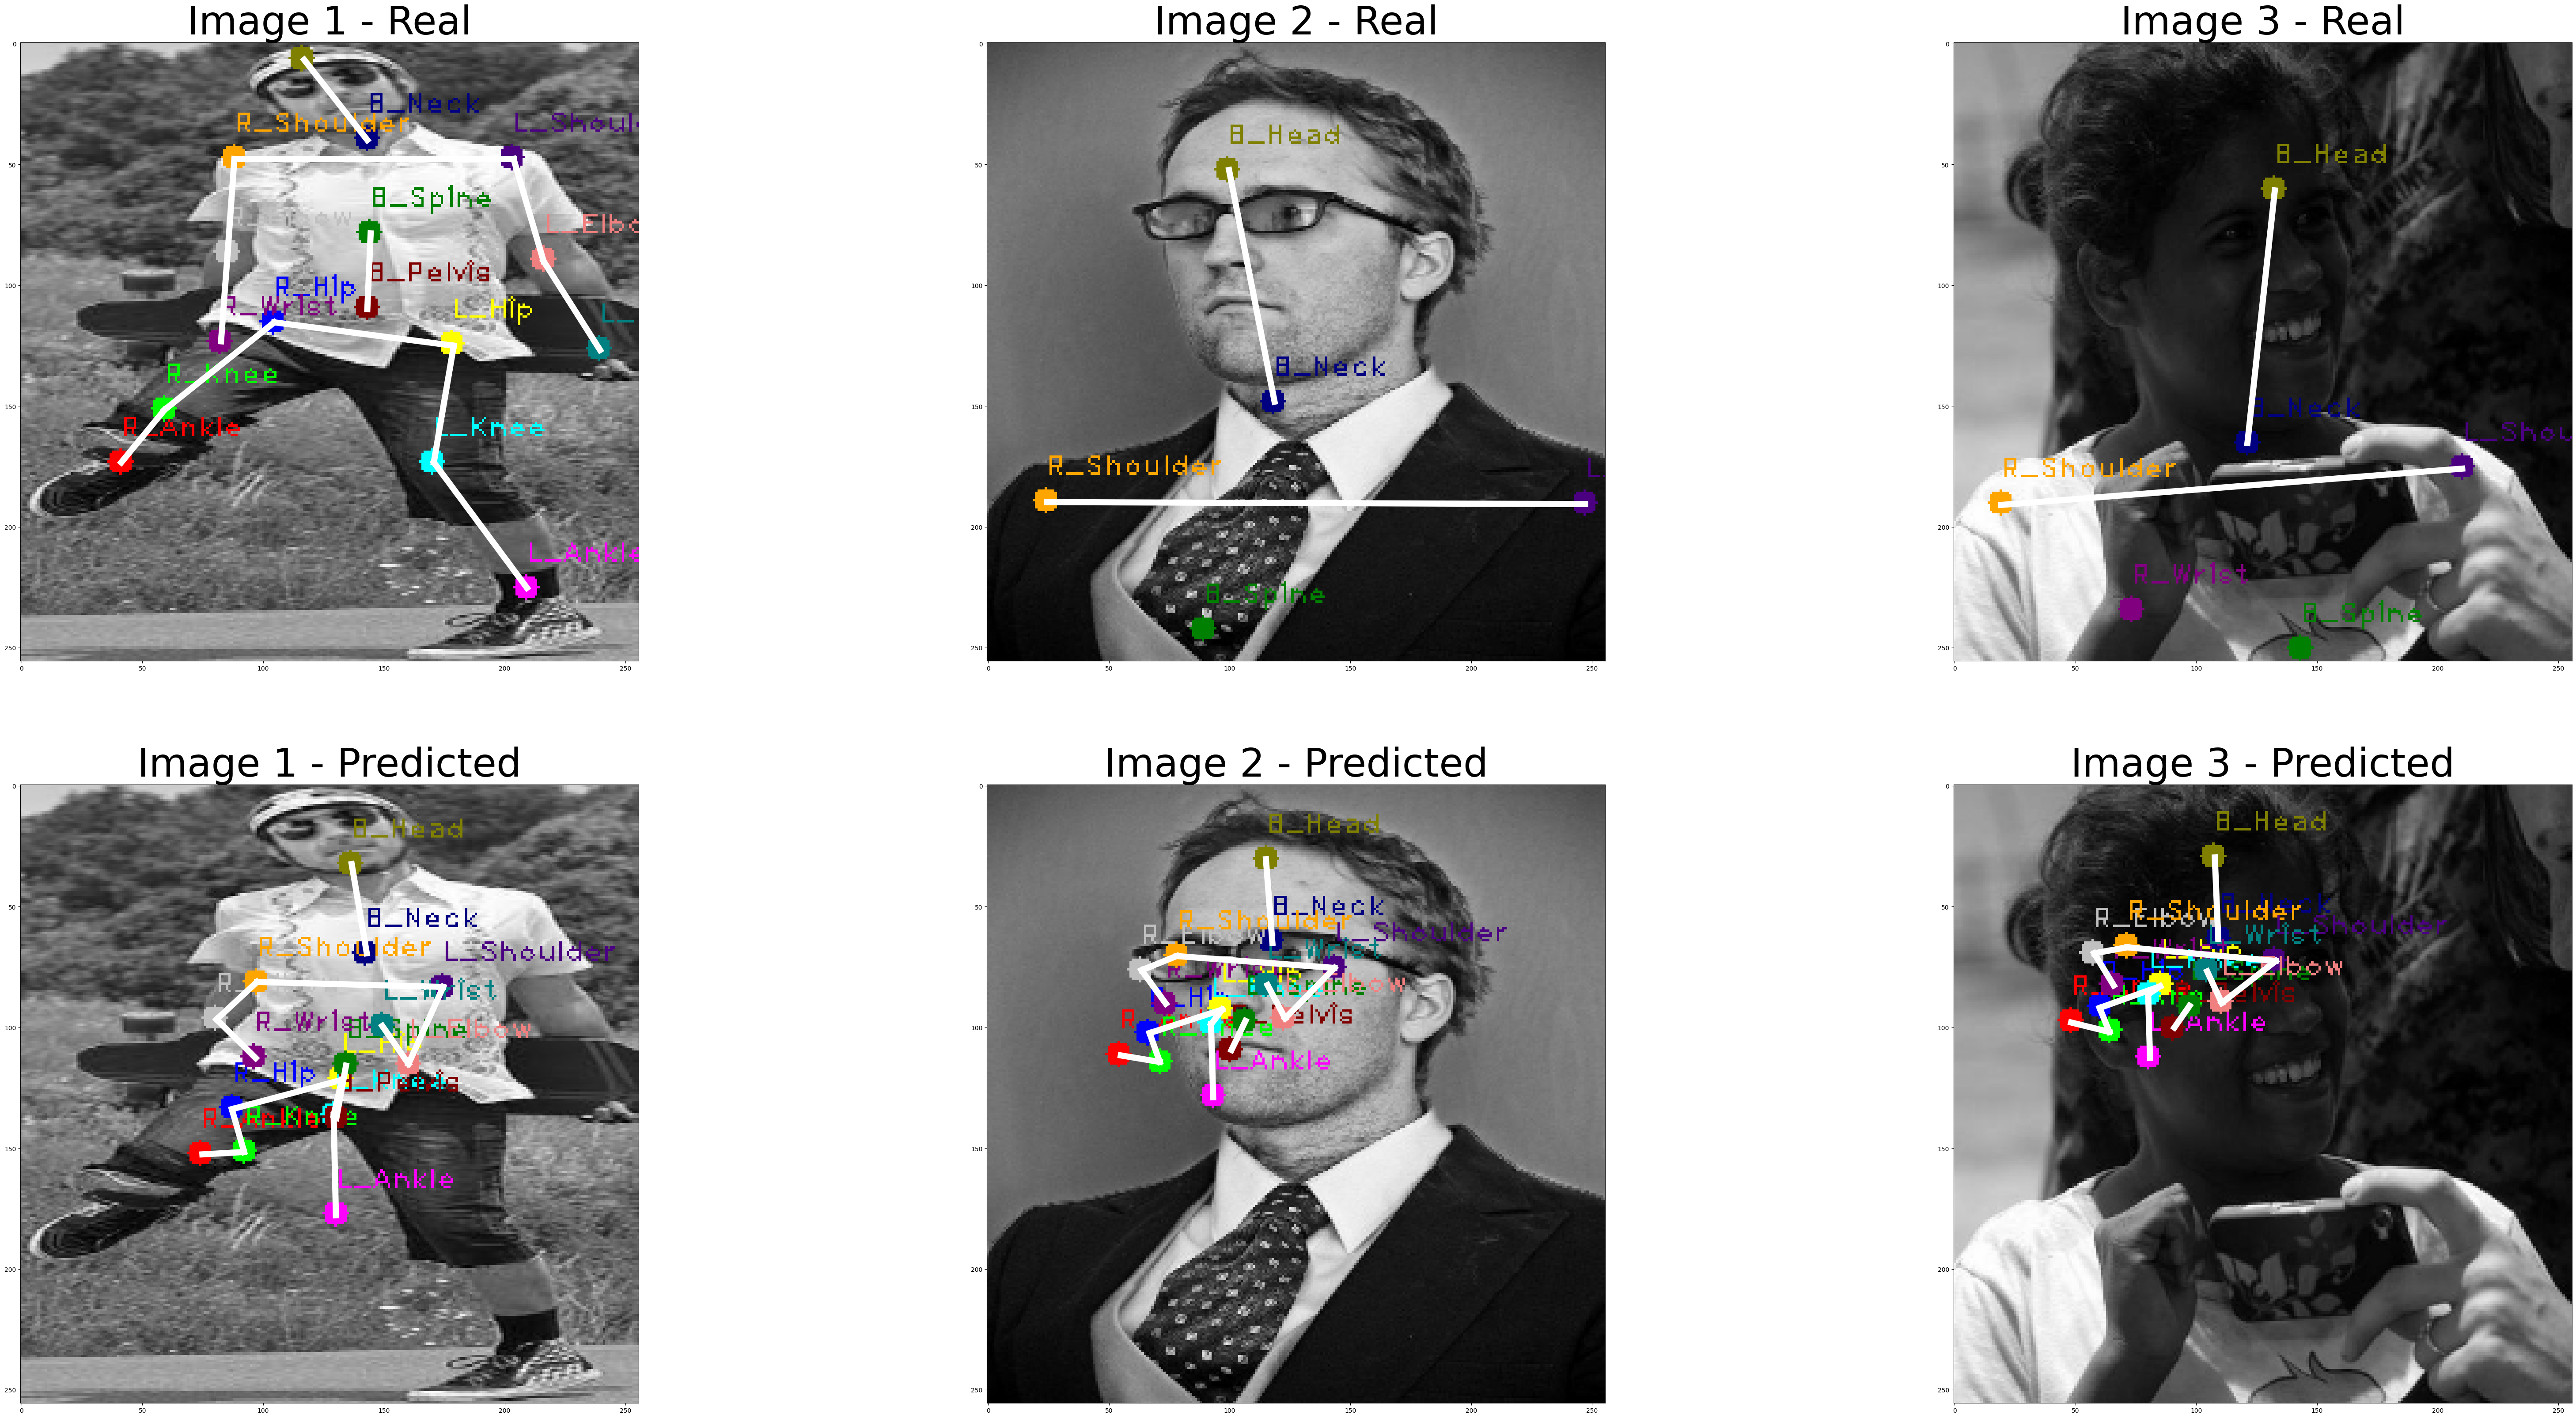

In [196]:
# Load the model
model = tf.keras.models.load_model('best_model.h5.keras')

# Collect training images, annotations, and model predictions
example_train = {
    'images': [],
    'real_annotations': [],
    'predictions': []
}

# Collect images and annotations from the training dataset
for image, annotation in train_ds.take(3): 
    # Append the original training image
    example_train['images'].append(image[0].numpy() * 255)  # Scale the image back to [0, 255]
    
    # Append the real annotations (scaled appropriately)
    example_train['real_annotations'].append(annotation[0].numpy() * IMAGE_SIZE[0])  # Scale keypoints

    # Prepare the image for prediction
    image_for_prediction = tf.expand_dims(image[0], axis=0)  # Expand dimensions for prediction
    train_predictions = model.predict(image_for_prediction)
    train_keypoints = train_predictions.squeeze(axis=0) * IMAGE_SIZE[0]  # Scale the predicted keypoints

    # Append the predicted keypoints
    example_train['predictions'].append(train_keypoints)

# Number of images to display
num_images = len(example_train['images'])

# Create a figure for plotting with 2 subplots
fig, axs = plt.subplots(2, num_images, figsize=(80, 40))

# Plot real annotations and model predictions
for i in range(num_images):    
    train_img = example_train['images'][i].astype("uint8")  # Convert to uint8 if needed
    real_kp = example_train['real_annotations'][i]
    pred_kp = example_train['predictions'][i]

    # Draw the real annotations
    draw_keypoints(parser, axs[0, i], train_img, real_kp, "Real Annotations")
    axs[0, i].set_title(f"Image {i+1} - Real", fontsize=64)

    # Draw the model's predictions
    draw_keypoints(parser, axs[1, i], train_img, pred_kp, "Model Predictions")
    axs[1, i].set_title(f"Image {i+1} - Predicted", fontsize=64)

plt.show()